In [4]:
# Build a QVM (Quality, Value, Momentum) ranking system and see the returns by decile

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.data import morningstar as mstar
from quantopian.pipeline.factors import Returns

In [5]:
def min_liq_univ():
    # replicate P123 universe "Minimum Liquidity NO OTC - Copy"
    # for 2005-01-03, this screen returns 3782 stocks.  P123 returns 4260 stocks.
    # for 2010-01-04, this screen returns 3543 stocks.  P123 returns 3686 stocks.
    # for 2016-01-01, this screen returns 3999 stocks.  P123 returns 3901 stocks.
    # for 2018-06-25, this screen returns 4428 stocks.  P123 returns 3894 stocks.
    
    # markt cap screen
    mktcap = Fundamentals.market_cap.latest
    mktcap_screen = mktcap > 50000000
    
    # price screen
    price_close = USEquityPricing.close.latest
    price_screen = price_close > 1
    
    # volume screen
    dollar_volume = AverageDollarVolume(window_length=20)
    volume_screen = dollar_volume > 200000
    
    # not OTC
    not_otc = ~mstar.share_class_reference.exchange_id.latest.startswith('OTC')
    
    return (mktcap_screen & price_screen & volume_screen & not_otc)
    

In [6]:
def make_pipeline():
    # get factors
    mktcap = Fundamentals.market_cap.latest
    price_close = USEquityPricing.close.latest
    
    # get factors, higher is better
    roe = Fundamentals.roe.latest
    fcf_yield = Fundamentals.fcf_yield.latest
    ret_20 = Returns(window_length = 20)
    
    # compare built-in valuation ratio with manually calculated
    price_close = USEquityPricing.close.latest
    fcf_per_share = Fundamentals.fcf_per_share.latest
    fcf_yield_manual = fcf_per_share / price_close
    
    # get ranks, masked by the universe, higher is better
    quality = roe.rank(method = 'average', mask = min_liq_univ())
    value = fcf_yield.rank(method = 'average', mask = min_liq_univ())
    momentum = ret_20.rank(method = 'average', mask = min_liq_univ())
    
    # combine ranks
    qvm = (quality + value + momentum).rank(method = 'average', mask = min_liq_univ())
    
    return Pipeline(
        columns={
            'mktcap': mktcap,
            'fcf_yield': fcf_yield,
            'fcf_yield_manual': fcf_yield_manual,
            'roe': roe,
            'ret_20': ret_20,
            'quality': quality,
            'value': value,
            'momentum': momentum,
            'qvm': qvm
        },
        screen = min_liq_univ()
    )

In [7]:
# Specify a time range to evaluate
period_start = '2012-06-25'
period_end = '2017-06-25'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In [8]:
#print('number of stocks: '+ str(len(pipeline_output)))
print('quality rank: ' + str(pipeline_output['quality'].min()) + ' to ' + str(pipeline_output['quality'].max()))
print('value rank: ' + str(pipeline_output['value'].min()) + ' to ' + str(pipeline_output['value'].max()))
print('momentum rank: ' + str(pipeline_output['momentum'].min()) + ' to ' + str(pipeline_output['momentum'].max()))
print('qvm rank: ' + str(pipeline_output['qvm'].min()) + ' to ' + str(pipeline_output['qvm'].max()))

quality rank: 1.0 to 4010.0
value rank: 1.0 to 4098.0
momentum rank: 1.0 to 4116.0
qvm rank: 1.0 to 3985.0


In [9]:
pipeline_output.sort_values(by = 'qvm', ascending = False).head(5)

fcf_yield  fcf_yield_manual  \
2015-06-29 00:00:00+00:00 Equity(19391 [ISLE])     0.1119          0.111910   
                          Equity(36845 [LINU])     0.2595          0.259434   
                          Equity(38633 [ASPS])     0.1253          0.125350   
                          Equity(162 [AEPI])       0.1939          0.194016   
2015-06-30 00:00:00+00:00 Equity(162 [AEPI])       0.1950          0.193667   

                                                     mktcap  momentum  \
2015-06-29 00:00:00+00:00 Equity(19391 [ISLE])  754757625.0    4037.0   
                          Equity(36845 [LINU])  128158905.0    3846.0   
                          Equity(38633 [ASPS])  632155036.0    3944.0   
                          Equity(162 [AEPI])    283197297.0    3613.0   
2015-06-30 00:00:00+00:00 Equity(162 [AEPI])    281666500.0    3924.0   

                                                quality     qvm    ret_20  \
2015-06-29 00:00:00+00:00 Equity(19391 [ISLE])   3843.0  3985.0  0.253456   
                          Equity(36845 [LINU])   3681.0  3984.0  0.136511   
                          Equity(38633 [ASPS])   3752.0  3983.0  0.172955   
                          Equity(162 [AEPI])     3879.0  3982.0  0.102106   
2015-06-30 00:00:00+00:00 Equity(162 [AEPI])     3877.0  3981.0  0.123509   

                                                     roe   value  
2015-06-29 00:00:00+00:00 Equity(19391 [ISLE])  0.129717  3781.0  
                          Equity(36845 [LINU])  0.077715  4029.0  
                          Equity(38633 [ASPS])  0.091114  3845.0  
                          Equity(162 [AEPI])    0.168388  3976.5  
2015-06-30 00:00:00+00:00 Equity(162 [AEPI])    0.168388  3969.0

In [10]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

In [11]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['qvm'],
    prices=asset_prices,
    quantiles=5,
    periods=(1,5,10),
)

# Display first 5 rows
factor_data.head(5)

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       11D  \
date                      asset                                             
2012-06-25 00:00:00+00:00 Equity(2 [ARNC])  -0.001217  0.027367 -0.001217   
                          Equity(24 [AAPL])  0.002390  0.038469  0.065518   
                          Equity(31 [ABAX]) -0.007636  0.101243  0.098158   
                          Equity(39 [DDC])  -0.012402 -0.023926  0.015137   
                          Equity(41 [ARCB]) -0.021543  0.016505 -0.037265   

                                             factor  factor_quantile  
date                      asset                                       
2012-06-25 00:00:00+00:00 Equity(2 [ARNC])   1676.0                3  
                          Equity(24 [AAPL])  3273.0                5  
                          Equity(31 [ABAX])  2670.0                4  
                          Equity(39 [DDC])   1562.0                3  
                          Equity(41 [ARCB])  1173.0                2

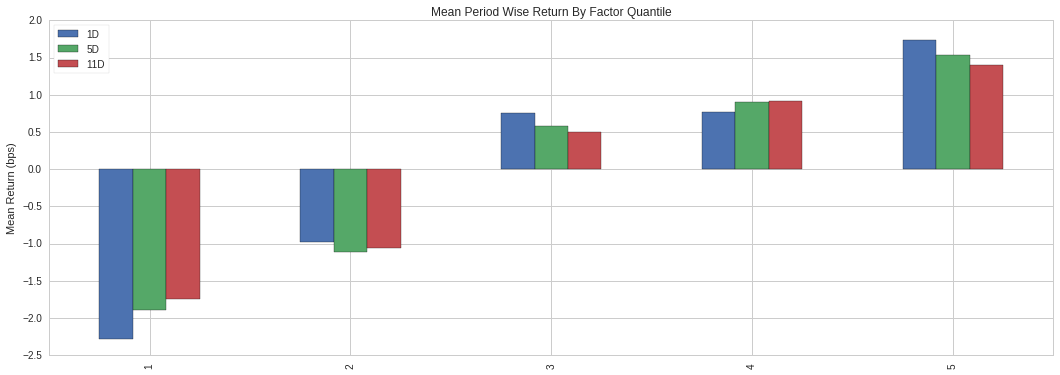

In [12]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

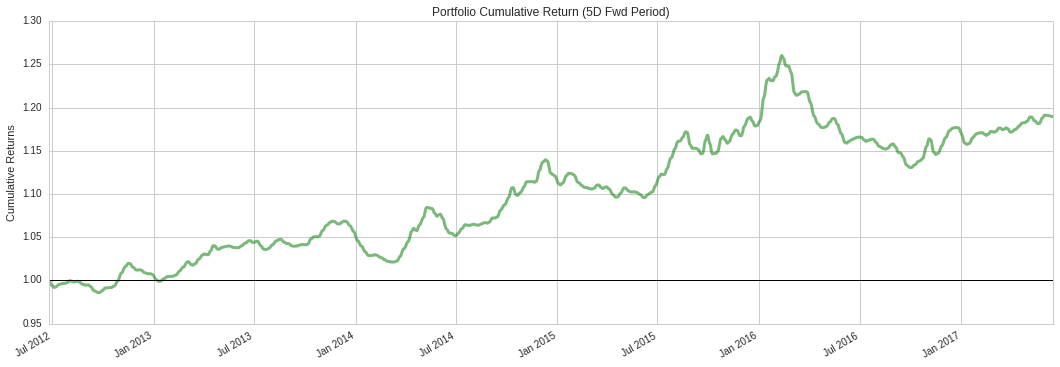

In [13]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D');